In [1]:
from google.colab import drive
import os


drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -r requirements.txt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import joblib

import sklearn
import xgboost
import lightgbm
import catboost

print(
    "sklearn:", sklearn.__version__,
    "| xgboost:", xgboost.__version__,
    "| lightgbm:", lightgbm.__version__,
    "| catboost:", catboost.__version__,
)

sklearn: 1.6.1 | xgboost: 3.1.2 | lightgbm: 4.6.0 | catboost: 1.2.8


In [4]:
url = "ILPD.csv"
df = pd.read_csv(url, header=None)

df.columns = [
    "Age",
    "Gender",
    "TB",
    "DB",
    "Alkphos",
    "SGPT",
    "SGOT",
    "TP",
    "ALB",
    "A/G Ratio",
    "is_patient",
]

df.head()

,Age,Gender,TB,DB,Alkphos,SGPT,SGOT,TP,ALB,A/G Ratio,is_patient
0,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
1,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
2,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
3,62,Male,7.3,4.1,490,60,68,7,3.3,0.89,1
4,58,Male,1,0.4,182,14,20,6.8,3.4,1,1


In [5]:
print("Dataset Shape:", df.shape)
df.describe()

Dataset Shape: (584, 11)


,Age,Gender,TB,DB,Alkphos,SGPT,SGOT,TP,ALB,A/G Ratio,is_patient
count,584,584,584,584,584,584,584,584,584,580,584
unique,73,3,114,81,264,153,178,59,41,70,3
top,60,Male,0.8,0.2,215,25,23,7,3,1,1
freq,34,441,91,194,11,25,16,32,45,106,416


Age           0
Gender        0
TB            0
DB            0
Alkphos       0
SGPT          0
SGOT          0
TP            0
ALB           0
A/G Ratio     4
is_patient    0
dtype: int64


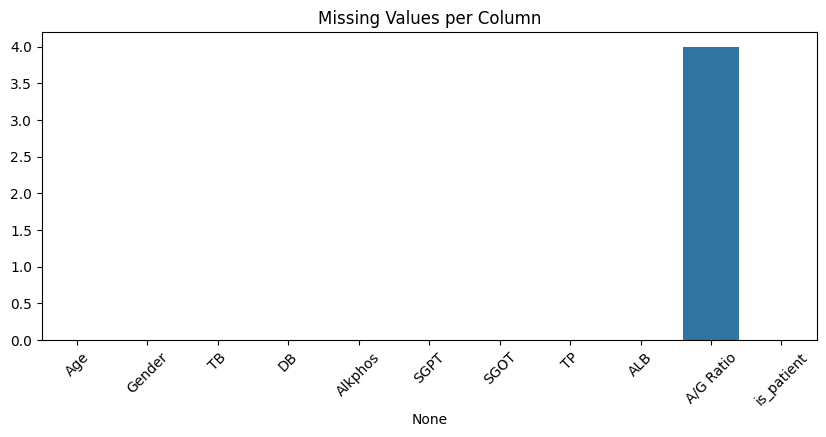

In [6]:
null_counts = df.isnull().sum()
print(null_counts)

plt.figure(figsize=(10, 4))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.xticks(rotation=45)
plt.title("Missing Values per Column")
plt.show()

In [7]:
df["A/G Ratio"] = pd.to_numeric(df["A/G Ratio"], errors="coerce")
df.dropna(inplace=True)

print("Shape after removing nulls:", df.shape)

Shape after removing nulls: (579, 11)


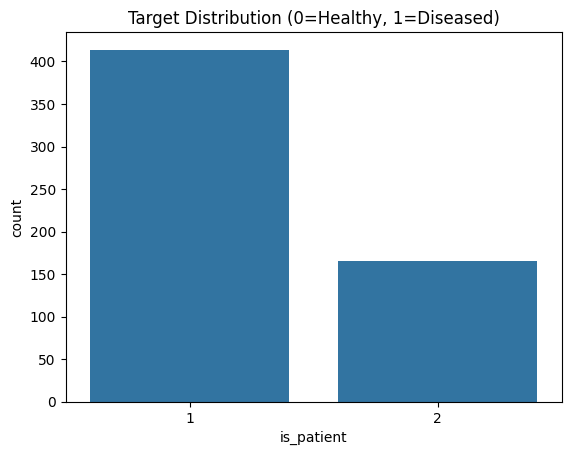

,count
is_patient,
1,414
2,165


In [8]:
df["Gender"] = LabelEncoder().fit_transform(df["Gender"].astype(str))
df["is_patient"] = df["is_patient"].replace(2, 0).astype(int)

sns.countplot(x="is_patient", data=df)
plt.title("Target Distribution (0=Healthy, 1=Diseased)")
plt.show()

df["is_patient"].value_counts()

In [9]:
X = df.drop("is_patient", axis=1)
y = df["is_patient"]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

X shape: (579, 10)
y distribution:
 is_patient
1    414
2    165
Name: count, dtype: int64


In [10]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,579.0,0.474214,0.188625,0.0,0.337209,0.476744,0.627907,1.0
Gender,579.0,0.758204,0.428542,0.0,1.000000,1.000000,1.000000,1.0
TB,579.0,0.039080,0.083481,0.0,0.005362,0.008043,0.029491,1.0
DB,579.0,0.071129,0.143699,0.0,0.005102,0.010204,0.061224,1.0
Alkphos,579.0,0.111561,0.118985,0.0,0.054958,0.070835,0.114802,1.0
SGPT,579.0,0.035742,0.092052,0.0,0.006533,0.012563,0.025628,1.0
SGOT,579.0,0.020414,0.058925,0.0,0.003049,0.006505,0.015654,1.0
TP,579.0,0.548071,0.157194,0.0,0.449275,0.565217,0.652174,1.0
ALB,579.0,0.486634,0.172703,0.0,0.369565,0.478261,0.630435,1.0
A/G Ratio,579.0,0.258826,0.127837,0.0,0.160000,0.252000,0.320000,1.0


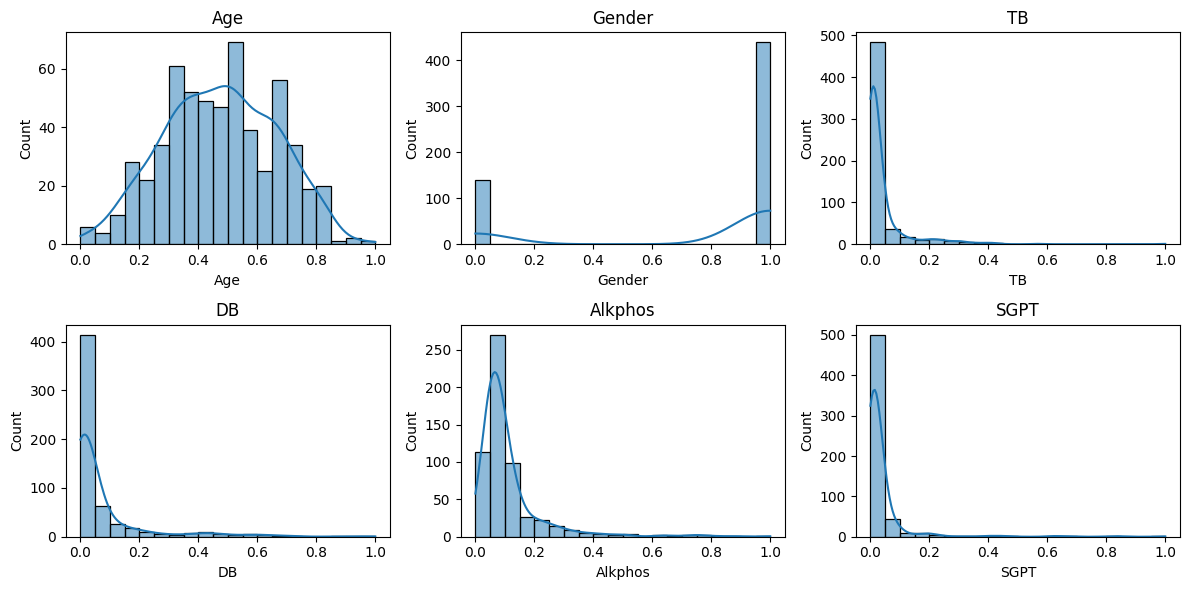

In [11]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns[:6]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_scaled_df[col], bins=20, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

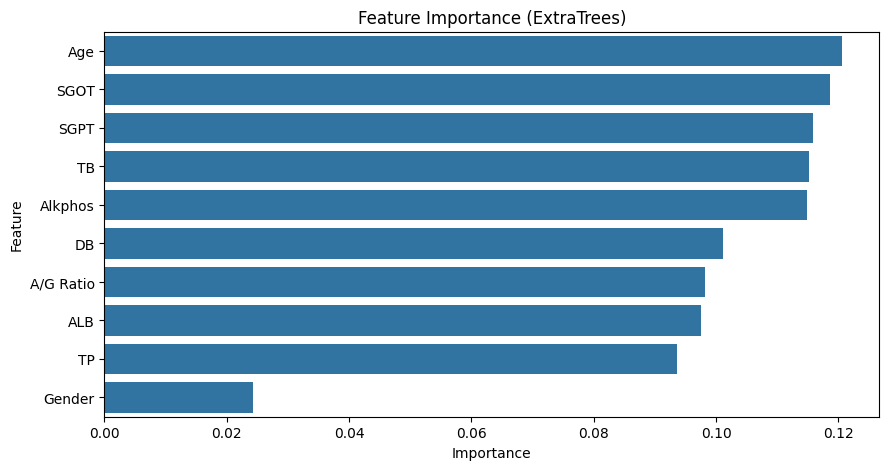

In [12]:
feature_selector = ExtraTreesClassifier(n_estimators=250, random_state=42)
feature_selector.fit(X_scaled, y)

importances = feature_selector.feature_importances_
feat_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feat_df)
plt.title("Feature Importance (ExtraTrees)")
plt.show()

In [13]:
model_selector = SelectFromModel(
    feature_selector, prefit=True, max_features=8
)
X_selected = model_selector.transform(X_scaled)

selected_features = X.columns[model_selector.get_support()]
print("Selected features:", selected_features.tolist())

Selected features: ['Age', 'TB', 'DB', 'Alkphos', 'SGPT', 'SGOT']


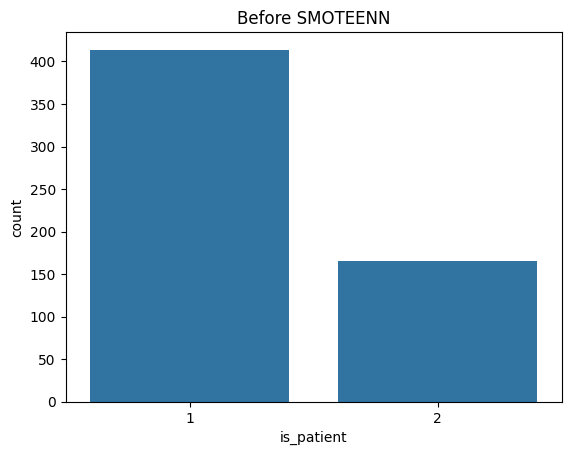

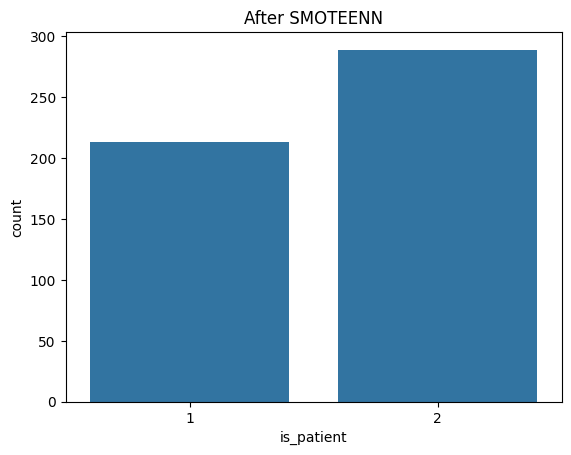

,count
is_patient,
2,289
1,213


In [14]:
sns.countplot(x=y)
plt.title("Before SMOTEENN")
plt.show()

smote_enn = SMOTEENN(random_state=42)
X_balanced, y_balanced = smote_enn.fit_resample(X_selected, y)

sns.countplot(x=y_balanced)
plt.title("After SMOTEENN")
plt.show()

pd.Series(y_balanced).value_counts()

In [15]:
base_learners = [
    ("xgb", XGBClassifier(
        n_estimators=600,
        learning_rate=0.015,
        max_depth=8,
        subsample=0.95,
        colsample_bytree=0.85,
        gamma=0.1,
        reg_lambda=2,
        use_label_encoder=False,
        eval_metric="logloss",
    )),
    ("et", ExtraTreesClassifier(n_estimators=400, max_depth=14, random_state=42)),
    ("lgbm", LGBMClassifier(n_estimators=600, learning_rate=0.01, max_depth=11)),
    ("cat", CatBoostClassifier(
        verbose=0,
        iterations=500,
        depth=9,
        learning_rate=0.01,
        l2_leaf_reg=5,
    )),
]

In [16]:
y_balanced = np.where(y_balanced == 2, 0, y_balanced).astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42,
)

metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "AUC": [],
}

for name, model in base_learners:
    model.fit(X_train_b, y_train_b)
    y_pred = model.predict(X_test_b)
    y_proba = model.predict_proba(X_test_b)[:, 1]

    metrics["Model"].append(name.upper())
    metrics["Accuracy"].append(accuracy_score(y_test_b, y_pred))
    metrics["Precision"].append(precision_score(y_test_b, y_pred))
    metrics["Recall"].append(recall_score(y_test_b, y_pred))
    metrics["F1"].append(f1_score(y_test_b, y_pred))
    metrics["AUC"].append(roc_auc_score(y_test_b, y_proba))

results_df = pd.DataFrame(metrics)
results_df

[LightGBM] [Info] Number of positive: 170, number of negative: 231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 401, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423940 -> initscore=-0.306619
[LightGBM] [Info] Start training from score -0.306619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGB,0.910891,0.869565,0.930233,0.898876,0.975942
1,ET,0.910891,0.925000,0.860465,0.891566,0.982358
2,LGBM,0.940594,0.911111,0.953488,0.931818,0.987971
3,CAT,0.930693,0.909091,0.930233,0.919540,0.983962


In [19]:
meta_learner = LogisticRegression(max_iter=1500, C=0.5, solver="liblinear")

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,
    cv=3, # 5
    n_jobs=-1,
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 15
cv_scores = cross_val_score(stack_model, X_balanced, y_balanced, cv=cv)

print("CV scores:", cv_scores)
print("Mean CV:", cv_scores.mean(), "±", cv_scores.std())

CV scores: [0.93069307 0.97029703 0.98       0.91       0.95      ]
Mean CV: 0.9481980198019802 ± 0.025567523635972086


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42,
)

stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.9207920792079208
AUC: 0.9819566960705693
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        58
           1       0.87      0.95      0.91        43

    accuracy                           0.92       101
   macro avg       0.92      0.93      0.92       101
weighted avg       0.92      0.92      0.92       101



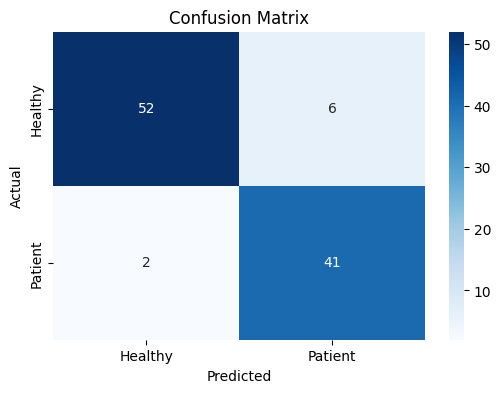

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Healthy", "Patient"],
    yticklabels=["Healthy", "Patient"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
joblib.dump(
    {
        "model": stack_model,
        "scaler": scaler,
        "selector": feature_selector,
        "selected_features": X.columns.tolist(),
    },
    "ensemble_model.pkl",
)

print("Model bundle saved as ensemble_model.pkl")

Model bundle saved as ensemble_model.pkl


In [23]:
%cp ensemble_model.pkl /content/drive/MyDrive/

ExactExplainer explainer: 102it [00:16,  4.06it/s]


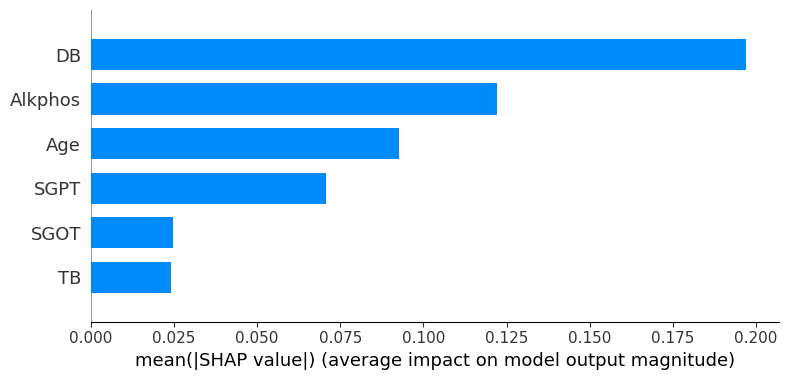

In [24]:
xgb_model = stack_model.named_estimators_["xgb"]

explainer = shap.Explainer(
    xgb_model.predict_proba,
    X_train,
    feature_names=np.array(X.columns)[model_selector.get_support()],
)

shap_values = explainer(X_test)

shap.summary_plot(
    shap_values[..., 1],
    X_test,
    feature_names=np.array(X.columns)[model_selector.get_support()],
    plot_type="bar",
)